In [1]:
import os
import zipfile
import requests

# Destination folder
DATASET_DIR = "dataset_eurosat_sample"
os.makedirs(DATASET_DIR, exist_ok=True)

# EuroSAT RGB dataset from Zenodo
URL = "https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip"
ZIP_PATH = "EuroSAT_RGB.zip"

# Download if not already
if not os.path.exists(ZIP_PATH):
    print("Downloading EuroSAT RGB dataset (~88 MB)...")
    r = requests.get(URL, stream=True)
    with open(ZIP_PATH, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

# Extract
print("Extracting...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall("eurosat_data")

print("Done!")


Extracting...
Done!


In [2]:
import shutil
from pathlib import Path

base_path = Path("/content/eurosat_data/EuroSAT_RGB")
DATASET_PATH = Path("dataset_eurosat_sample/")
DATASET_PATH.mkdir(exist_ok=True)

classes = ["AnnualCrop", "Forest", "River", "Residential"]
num_to_copy = 20  # per class

for cls in classes:
    class_folder = base_path / cls
    images = list(class_folder.glob("*.jpg"))
    print(f"{cls}: {len(images)} images available")
    for src in images[:num_to_copy]:
        shutil.copy(src, DATASET_PATH / f"{cls}_{src.name}")

print("Copied sample images into dataset_eurosat_sample/")


AnnualCrop: 3000 images available
Forest: 3000 images available
River: 2500 images available
Residential: 3000 images available
Copied sample images into dataset_eurosat_sample/


In [2]:
!pip install faiss-cpu --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 61.2 MB/s eta 0:00:00


In [4]:
import os
import json
import warnings
from pathlib import Path
from typing import List, Tuple, Optional, Dict, Any
import pickle

# Data handling
import numpy as np
from PIL import Image
import tifffile  # For GeoTIFF support

# Deep Learning
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Similarity search
import faiss

# Utilities
from sklearn.preprocessing import normalize
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Automatically set patch size to (78, 88) based on query image
Using patch size (78, 88) based on query image dimensions
Processing dataset images...


Processing images: 100%|██████████| 2/2 [00:43<00:00, 21.89s/it]


Building Flat index with 170 vectors...
Index built with 170 vectors
Processed 170 patches from 2 images
Index saved to satellite_index
Visualization saved to retrieval_results.png


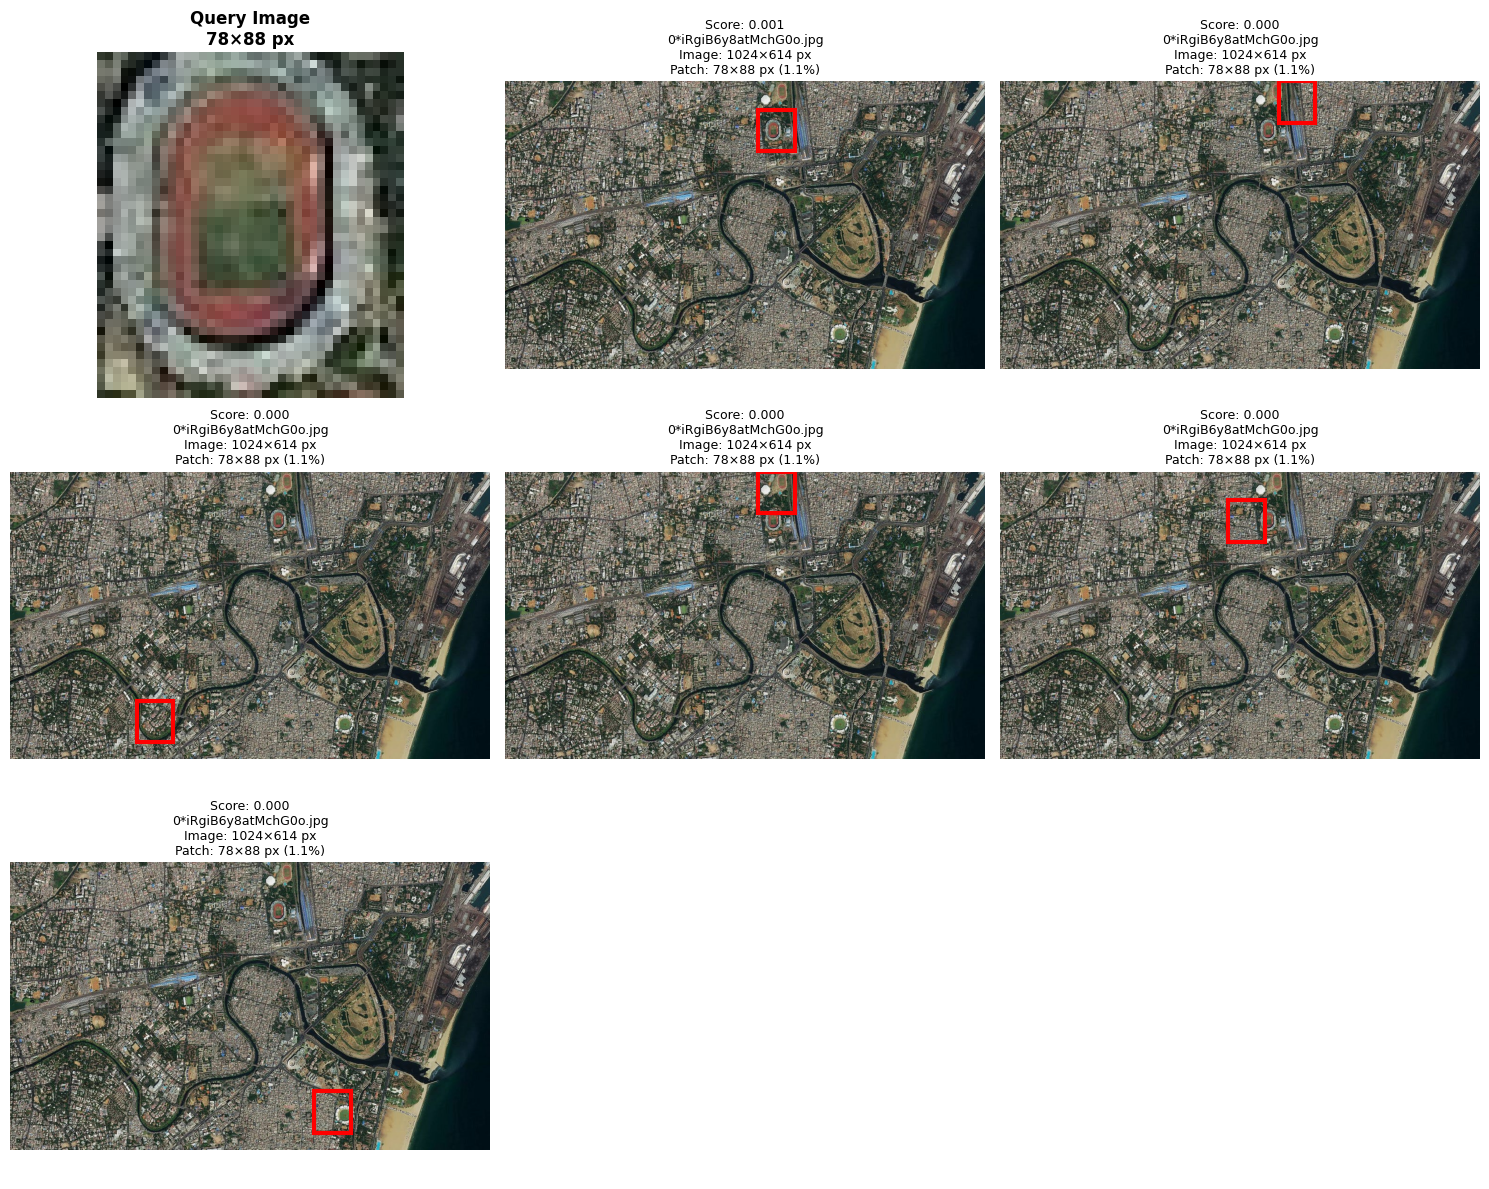

Found 20 unique matches after NMS

=== PATCH SIZE ANALYSIS ===
Patch dimensions: 78×88 pixels
Patch area: 6,864 pixels²

=== DETAILED RESULTS ===

Match 1:
  Image: 0*iRgiB6y8atMchG0o.jpg
  Image size: 1024×614 pixels
  Patch location: (540, 61)
  Patch size: 78×88 pixels
  Coverage: 1.1% of source image
  Similarity: 0.0007

Match 2:
  Image: 0*iRgiB6y8atMchG0o.jpg
  Image size: 1024×614 pixels
  Patch location: (594, 0)
  Patch size: 78×88 pixels
  Coverage: 1.1% of source image
  Similarity: 0.0004

Match 3:
  Image: 0*iRgiB6y8atMchG0o.jpg
  Image size: 1024×614 pixels
  Patch location: (270, 488)
  Patch size: 78×88 pixels
  Coverage: 1.1% of source image
  Similarity: 0.0004

Match 4:
  Image: 0*iRgiB6y8atMchG0o.jpg
  Image size: 1024×614 pixels
  Patch location: (540, 0)
  Patch size: 78×88 pixels
  Coverage: 1.1% of source image
  Similarity: 0.0004

Match 5:
  Image: 0*iRgiB6y8atMchG0o.jpg
  Image size: 1024×614 pixels
  Patch location: (486, 61)
  Patch size: 78×88 pixels
  Co

In [7]:
"""
Patch-Based Query Retrieval System for Satellite Images
========================================================
A comprehensive system for finding similar patches in satellite imagery using
state-of-the-art vision models and efficient similarity search.
"""

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict, Optional, Union
from dataclasses import dataclass
from pathlib import Path
import cv2
from PIL import Image
import faiss
from tqdm import tqdm
import json
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict


@dataclass
class PatchInfo:
    """Store information about a patch"""
    image_path: str
    image_idx: int
    x: int
    y: int
    width: int
    height: int
    embedding: Optional[np.ndarray] = None


@dataclass
class RetrievalResult:
    """Store retrieval results"""
    patch_info: PatchInfo
    similarity_score: float
    query_image: np.ndarray


class SatelliteModelWrapper:
    """
    Wrapper for satellite image models (DINOv2, SatMAE, etc.)
    Provides a unified interface for feature extraction.
    """

    def __init__(self, model_name: str = "dinov2", device: str = "cuda"):
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        self.model, self.preprocess = self._load_model()

    def _load_model(self):
        """Load the specified satellite image model"""
        if self.model_name == "dinov2":
            # DINOv2 - Vision Transformer trained on diverse data
            model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
            model = model.to(self.device)
            model.eval()

            # DINOv2 preprocessing
            from torchvision import transforms
            preprocess = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])

        elif self.model_name == "resnet":
            # ResNet as a baseline
            from torchvision import models
            model = models.resnet50(pretrained=True)
            # Remove the final classification layer
            model = nn.Sequential(*list(model.children())[:-1])
            model = model.to(self.device)
            model.eval()

            from torchvision import transforms
            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])

        else:
            raise ValueError(f"Unsupported model: {self.model_name}")

        return model, preprocess

    @torch.no_grad()
    def extract_features(self, images: Union[torch.Tensor, np.ndarray]) -> np.ndarray:
        """Extract features from a batch of images"""
        if isinstance(images, np.ndarray):
            # Convert numpy array to tensor
            images = torch.from_numpy(images).to(self.device)
        else:
            images = images.to(self.device)

        features = self.model(images)

        # Handle different output formats
        if isinstance(features, dict):
            features = features['x_norm_patchtokens'].mean(dim=1)  # DINOv2 format
        elif len(features.shape) == 4:
            features = features.squeeze(-1).squeeze(-1)  # ResNet format

        return features.cpu().numpy()


class PatchDataset(Dataset):
    """Dataset for efficiently loading and processing patches"""

    def __init__(self, image_path: str, patch_size: Tuple[int, int],
                 stride: Tuple[int, int], transform=None):
        self.image_path = image_path
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        # Load image
        self.image = cv2.imread(image_path)
        if self.image is None:
            raise ValueError(f"Could not load image: {image_path}")
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.h, self.w = self.image.shape[:2]

        # Calculate patch positions
        self.patches = []
        for y in range(0, self.h - patch_size[1] + 1, stride[1]):
            for x in range(0, self.w - patch_size[0] + 1, stride[0]):
                self.patches.append((x, y))

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        x, y = self.patches[idx]
        patch = self.image[y:y+self.patch_size[1], x:x+self.patch_size[0]]

        if self.transform:
            patch = Image.fromarray(patch)
            patch = self.transform(patch)

        return patch, (x, y)


class PatchRetrievalSystem:
    """
    Main class for patch-based satellite image retrieval
    """

    def __init__(self,
                 model_name: str = "dinov2",
                 index_type: str = "auto",
                 device: str = "cuda",
                 batch_size: int = 32):
        """
        Initialize the retrieval system

        Args:
            model_name: Name of the model to use ('dinov2', 'resnet', etc.)
            index_type: FAISS index type ('Flat', 'IVF_PQ', 'HNSW', 'auto')
            device: Device to run the model on
            batch_size: Batch size for processing patches
        """
        self.model_wrapper = SatelliteModelWrapper(model_name, device)
        self.index_type = index_type
        self.batch_size = batch_size
        self.index = None
        self.patch_database = []
        self.dimension = None

    def get_image_dimensions(self, image_path: str) -> Tuple[int, int]:
        """
        Get dimensions of an image file

        Args:
            image_path: Path to the image file

        Returns:
            Tuple of (width, height)
        """
        try:
            img = cv2.imread(image_path)
            if img is not None:
                h, w = img.shape[:2]
                return (w, h)
            else:
                raise ValueError(f"Could not load image: {image_path}")
        except Exception as e:
            raise ValueError(f"Error loading image {image_path}: {e}")

    def process_dataset_with_query_size(self,
                                      image_paths: List[str],
                                      query_image_path: str,
                                      overlap_ratio: float = 0.5) -> None:
        """
        Process dataset using query image dimensions as patch size

        Args:
            image_paths: List of paths to satellite images
            query_image_path: Path to query image (determines patch size)
            overlap_ratio: Overlap ratio between patches (0-1)
        """
        # Get patch size from query image
        patch_size = self.get_image_dimensions(query_image_path)
        print(f"Using patch size {patch_size} based on query image dimensions")

        # Process dataset with determined patch size
        self.process_dataset(image_paths, patch_size, overlap_ratio)

    def extract_query_embedding(self, query_image: Union[str, np.ndarray]) -> np.ndarray:
        """Extract embedding for a query image"""
        if isinstance(query_image, str):
            img = Image.open(query_image).convert('RGB')
        else:
            img = Image.fromarray(query_image)

        # Preprocess and extract features
        img_tensor = self.model_wrapper.preprocess(img).unsqueeze(0)
        embedding = self.model_wrapper.extract_features(img_tensor)

        return embedding.flatten()
        """Extract embedding for a query image"""
        if isinstance(query_image, str):
            img = Image.open(query_image).convert('RGB')
        else:
            img = Image.fromarray(query_image)

        # Preprocess and extract features
        img_tensor = self.model_wrapper.preprocess(img).unsqueeze(0)
        embedding = self.model_wrapper.extract_features(img_tensor)

    def extract_query_embedding(self, query_image: Union[str, np.ndarray]) -> np.ndarray:
        """Extract embedding for a query image"""
        if isinstance(query_image, str):
            img = Image.open(query_image).convert('RGB')
        else:
            img = Image.fromarray(query_image)

        # Preprocess and extract features
        img_tensor = self.model_wrapper.preprocess(img).unsqueeze(0)
        embedding = self.model_wrapper.extract_features(img_tensor)

        return embedding.flatten()

    def process_dataset(self,
                       image_paths: List[str],
                       patch_size: Tuple[int, int],
                       overlap_ratio: float = 0.5) -> None:
        """
        Process a dataset of satellite images and build the index

        Args:
            image_paths: List of paths to satellite images
            patch_size: Size of patches (width, height)
            overlap_ratio: Overlap ratio between patches (0-1)
        """
        print("Processing dataset images...")

        # Calculate stride from overlap ratio
        stride = (int(patch_size[0] * (1 - overlap_ratio)),
                 int(patch_size[1] * (1 - overlap_ratio)))

        all_embeddings = []

        for img_idx, img_path in enumerate(tqdm(image_paths, desc="Processing images")):
            try:
                # Create dataset for this image
                dataset = PatchDataset(img_path, patch_size, stride,
                                     self.model_wrapper.preprocess)

                # Use fewer workers for small datasets
                num_workers = min(2, len(dataset) // 4) if len(dataset) > 4 else 0
                dataloader = DataLoader(dataset, batch_size=self.batch_size,
                                       shuffle=False, num_workers=num_workers)

                # Process patches in batches
                for batch_patches, positions in tqdm(dataloader, desc=f"Image {img_idx+1}",
                                                   leave=False):
                    embeddings = self.model_wrapper.extract_features(batch_patches)

                    # Store patch information
                    for emb, (x, y) in zip(embeddings, zip(*positions)):
                        patch_info = PatchInfo(
                            image_path=img_path,
                            image_idx=img_idx,
                            x=x.item(),
                            y=y.item(),
                            width=patch_size[0],
                            height=patch_size[1],
                            embedding=emb
                        )
                        self.patch_database.append(patch_info)
                        all_embeddings.append(emb)

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

        if not all_embeddings:
            raise ValueError("No patches were successfully extracted from the dataset")

        # Convert to numpy array
        all_embeddings = np.array(all_embeddings).astype('float32')
        self.dimension = all_embeddings.shape[1]

        # Build FAISS index
        self._build_index(all_embeddings)

        print(f"Processed {len(self.patch_database)} patches from {len(image_paths)} images")

    def _build_index(self, embeddings: np.ndarray) -> None:
        """Build FAISS index for efficient similarity search"""
        n_samples = embeddings.shape[0]

        # Auto-select index type based on dataset size
        if self.index_type == "auto":
            if n_samples < 1000:
                selected_index_type = "Flat"
            elif n_samples < 100000:
                selected_index_type = "HNSW"
            else:
                selected_index_type = "IVF_PQ"
        else:
            selected_index_type = self.index_type

        print(f"Building {selected_index_type} index with {n_samples} vectors...")

        if selected_index_type == "Flat":
            # Exact search - good for small datasets
            self.index = faiss.IndexFlatL2(self.dimension)

        elif selected_index_type == "IVF_PQ":
            # Inverted File with Product Quantization - good for large datasets
            # Ensure we have enough samples for clustering
            nlist = max(4, min(int(np.sqrt(n_samples)), n_samples // 39))  # At least 39 points per cluster
            nlist = min(nlist, 1024)  # Cap at 1024 clusters

            # Ensure we have enough dimensions for PQ
            m = min(max(1, self.dimension // 8), 64)  # At least 8 dimensions per subquantizer

            if n_samples < nlist * 39:  # Not enough samples for IVF_PQ, fall back to Flat
                print(f"Not enough samples ({n_samples}) for IVF_PQ with {nlist} clusters. Using Flat index.")
                self.index = faiss.IndexFlatL2(self.dimension)
            else:
                quantizer = faiss.IndexFlatL2(self.dimension)
                self.index = faiss.IndexIVFPQ(quantizer, self.dimension, nlist, m, 8)

                # Train the index
                print(f"Training IVF-PQ index with {nlist} clusters, {m} subquantizers...")
                self.index.train(embeddings)

        elif selected_index_type == "HNSW":
            # Hierarchical Navigable Small World - good balance
            M = 32  # Number of connections per layer
            self.index = faiss.IndexHNSWFlat(self.dimension, M)

        else:
            raise ValueError(f"Unsupported index type: {selected_index_type}")

        # Add embeddings to index
        self.index.add(embeddings)
        print(f"Index built with {self.index.ntotal} vectors")

    def search(self,
              query_image: Union[str, np.ndarray],
              top_k: int = 10,
              nprobe: int = 10) -> List[RetrievalResult]:
        """
        Search for similar patches in the dataset

        Args:
            query_image: Query patch (path or numpy array)
            top_k: Number of top results to return
            nprobe: Number of clusters to search (for IVF indices)
        """
        if self.index is None:
            raise ValueError("Index not built. Run process_dataset first.")

        # Extract query embedding
        query_embedding = self.extract_query_embedding(query_image)
        query_embedding = query_embedding.reshape(1, -1).astype('float32')

        # Set search parameters for IVF indices
        if hasattr(self.index, 'nprobe'):
            self.index.nprobe = min(nprobe, self.index.nlist)  # Ensure nprobe <= nlist

        # Perform search
        distances, indices = self.index.search(query_embedding, top_k)

        # Load query image for visualization
        if isinstance(query_image, str):
            query_img = cv2.imread(query_image)
            if query_img is not None:
                query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
            else:
                # Create a placeholder if image can't be loaded
                query_img = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            query_img = query_image

        # Create results
        results = []
        for dist, idx in zip(distances[0], indices[0]):
            if idx != -1:  # Valid result
                patch_info = self.patch_database[idx]
                result = RetrievalResult(
                    patch_info=patch_info,
                    similarity_score=1.0 / (1.0 + dist),  # Convert distance to similarity
                    query_image=query_img
                )
                results.append(result)

        return results

    def apply_nms(self,
                  results: List[RetrievalResult],
                  iou_threshold: float = 0.5) -> List[RetrievalResult]:
        """
        Apply Non-Maximum Suppression to remove overlapping detections

        Args:
            results: List of retrieval results
            iou_threshold: IoU threshold for suppression
        """
        # Group results by image
        image_groups = defaultdict(list)
        for result in results:
            image_groups[result.patch_info.image_path].append(result)

        filtered_results = []

        for img_path, img_results in image_groups.items():
            # Sort by similarity score
            img_results.sort(key=lambda x: x.similarity_score, reverse=True)

            # Apply NMS
            keep = []
            for i, result in enumerate(img_results):
                suppress = False
                for kept_result in keep:
                    if self._compute_iou(result.patch_info, kept_result.patch_info) > iou_threshold:
                        suppress = True
                        break

                if not suppress:
                    keep.append(result)

            filtered_results.extend(keep)

        return filtered_results

    def _compute_iou(self, patch1: PatchInfo, patch2: PatchInfo) -> float:
        """Compute Intersection over Union between two patches"""
        x1_min, y1_min = patch1.x, patch1.y
        x1_max, y1_max = x1_min + patch1.width, y1_min + patch1.height

        x2_min, y2_min = patch2.x, patch2.y
        x2_max, y2_max = x2_min + patch2.width, y2_min + patch2.height

        # Calculate intersection
        x_inter_min = max(x1_min, x2_min)
        y_inter_min = max(y1_min, y2_min)
        x_inter_max = min(x1_max, x2_max)
        y_inter_max = min(y1_max, y2_max)

        if x_inter_max < x_inter_min or y_inter_max < y_inter_min:
            return 0.0

        intersection = (x_inter_max - x_inter_min) * (y_inter_max - y_inter_min)
        area1 = patch1.width * patch1.height
        area2 = patch2.width * patch2.height
        union = area1 + area2 - intersection

        return intersection / union if union > 0 else 0.0

    def visualize_results(self,
                         results: List[RetrievalResult],
                         num_display: int = 6,
                         save_path: Optional[str] = None,
                         show_size_info: bool = True) -> None:
        """
        Visualize retrieval results with bounding boxes and size information

        Args:
            results: List of retrieval results
            num_display: Number of results to display
            save_path: Path to save the visualization
            show_size_info: Whether to display size information
        """
        if not results:
            print("No results to visualize")
            return

        num_display = min(num_display, len(results))

        # Create figure
        cols = min(3, num_display + 1)  # Max 3 columns
        rows = (num_display + 1 + cols - 1) // cols  # Calculate rows needed

        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1) if cols > 1 else [axes]
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

        # Display query image with size info
        query_img = results[0].query_image
        axes[0].imshow(query_img)

        if show_size_info:
            query_h, query_w = query_img.shape[:2]
            title = f"Query Image\n{query_w}×{query_h} px"
        else:
            title = "Query Image"

        axes[0].set_title(title, fontsize=12, fontweight='bold')
        axes[0].axis('off')

        # Display retrieved patches
        for idx, result in enumerate(results[:num_display]):
            ax_idx = idx + 1
            if ax_idx >= len(axes):
                break

            ax = axes[ax_idx]

            # Load the source image
            try:
                img = cv2.imread(result.patch_info.image_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_h, img_w = img.shape[:2]
                else:
                    img = np.zeros((512, 512, 3), dtype=np.uint8)
                    img_h, img_w = 512, 512

                # Display image
                ax.imshow(img)

                # Add bounding box
                rect = mpatches.Rectangle(
                    (result.patch_info.x, result.patch_info.y),
                    result.patch_info.width,
                    result.patch_info.height,
                    linewidth=3,
                    edgecolor='red',
                    facecolor='none'
                )
                ax.add_patch(rect)

                # Calculate patch coverage percentage
                patch_area = result.patch_info.width * result.patch_info.height
                total_area = img_w * img_h
                coverage_pct = (patch_area / total_area) * 100

                # Set title with comprehensive size information
                if show_size_info:
                    title = (f"Score: {result.similarity_score:.3f}\n"
                           f"{Path(result.patch_info.image_path).name}\n"
                           f"Image: {img_w}×{img_h} px\n"
                           f"Patch: {result.patch_info.width}×{result.patch_info.height} px "
                           f"({coverage_pct:.1f}%)")
                else:
                    title = f"Score: {result.similarity_score:.3f}\n{Path(result.patch_info.image_path).name}"

                ax.set_title(title, fontsize=9)
                ax.axis('off')

            except Exception as e:
                ax.text(0.5, 0.5, f"Error loading image:\n{e}",
                       ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')

        # Hide unused subplots
        for idx in range(num_display + 1, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")

        plt.show()

    def save_index(self, path: str) -> None:
        """Save the index and patch database to disk"""
        # Save FAISS index
        faiss.write_index(self.index, f"{path}_index.faiss")

        # Save patch database
        with open(f"{path}_patches.pkl", 'wb') as f:
            pickle.dump(self.patch_database, f)

        # Save metadata
        metadata = {
            'dimension': self.dimension,
            'index_type': self.index_type,
            'num_patches': len(self.patch_database)
        }
        with open(f"{path}_metadata.json", 'w') as f:
            json.dump(metadata, f)

        print(f"Index saved to {path}")

    def load_index(self, path: str) -> None:
        """Load a saved index and patch database"""
        # Load FAISS index
        self.index = faiss.read_index(f"{path}_index.faiss")

        # Load patch database
        with open(f"{path}_patches.pkl", 'rb') as f:
            self.patch_database = pickle.load(f)

        # Load metadata
        with open(f"{path}_metadata.json", 'r') as f:
            metadata = json.load(f)
            self.dimension = metadata['dimension']

        print(f"Index loaded from {path}")


def main():
    """Example usage of the patch retrieval system"""

    # Initialize the system with auto index selection
    retrieval_system = PatchRetrievalSystem(
        model_name="dinov2",  # or "resnet"
        index_type="auto",    # Will automatically choose the best index type
        device="cuda" if torch.cuda.is_available() else "cpu",
        batch_size=16  # Reduced batch size for better compatibility
    )

    # Example dataset paths - replace with your actual paths
    dataset_images = [
        "/content/images-2.jpeg",
        "/content/0*iRgiB6y8atMchG0o.jpg",
    ]

    # Query image path - we'll determine patch size from this
    query_image_path = "/content/01.png"

    # Automatically determine patch size from query image
    try:
        if isinstance(query_image_path, str):
            query_img = cv2.imread(query_image_path)
            if query_img is not None:
                query_h, query_w = query_img.shape[:2]
                patch_size = (query_w, query_h)  # Use query image dimensions as patch size
                print(f"Automatically set patch size to {patch_size} based on query image")
            else:
                print(f"Warning: Could not load query image {query_image_path}, using default patch size")
                patch_size = (256, 256)  # Fallback to default
        else:
            print("Query image is not a file path, using default patch size")
            patch_size = (256, 256)  # Fallback to default
    except Exception as e:
        print(f"Error determining patch size from query image: {e}, using default")
        patch_size = (256, 256)  # Fallback to default

    overlap_ratio = 0.3      # 30% overlap between patches (less overlap = fewer patches)

    try:
        # Method 1: Use the convenience function (recommended)
        retrieval_system.process_dataset_with_query_size(
            image_paths=dataset_images,
            query_image_path=query_image_path,
            overlap_ratio=overlap_ratio
        )

        # Alternative Method 2: Manual approach (if you want more control)
        # retrieval_system.process_dataset(
        #     image_paths=dataset_images,
        #     patch_size=patch_size,
        #     overlap_ratio=overlap_ratio
        # )

        # Save the index for future use
        retrieval_system.save_index("satellite_index")

        # Perform a search with the same query image used to determine patch size
        results = retrieval_system.search(
            query_image=query_image_path,
            top_k=20,
            nprobe=10
        )

        # Apply Non-Maximum Suppression
        filtered_results = retrieval_system.apply_nms(
            results,
            iou_threshold=0.5
        )

        # Visualize results
        retrieval_system.visualize_results(
            filtered_results,
            num_display=6,
            save_path="retrieval_results.png",
            show_size_info=True
        )

        print(f"Found {len(filtered_results)} unique matches after NMS")

        # Print detailed results with size information
        print(f"\n=== PATCH SIZE ANALYSIS ===")
        if len(filtered_results) > 0:
            sample_patch = filtered_results[0].patch_info
            print(f"Patch dimensions: {sample_patch.width}×{sample_patch.height} pixels")
            print(f"Patch area: {sample_patch.width * sample_patch.height:,} pixels²")

        print(f"\n=== DETAILED RESULTS ===")
        for i, result in enumerate(filtered_results[:5]):
            # Load image to get its dimensions
            try:
                img = cv2.imread(result.patch_info.image_path)
                if img is not None:
                    img_h, img_w = img.shape[:2]
                    patch_coverage = (result.patch_info.width * result.patch_info.height) / (img_w * img_h) * 100
                else:
                    img_w, img_h, patch_coverage = "N/A", "N/A", "N/A"
            except:
                img_w, img_h, patch_coverage = "N/A", "N/A", "N/A"

            print(f"\nMatch {i+1}:")
            print(f"  Image: {Path(result.patch_info.image_path).name}")
            print(f"  Image size: {img_w}×{img_h} pixels")
            print(f"  Patch location: ({result.patch_info.x}, {result.patch_info.y})")
            print(f"  Patch size: {result.patch_info.width}×{result.patch_info.height} pixels")
            if isinstance(patch_coverage, float):
                print(f"  Coverage: {patch_coverage:.1f}% of source image")
            print(f"  Similarity: {result.similarity_score:.4f}")

    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    # Run the example
    main()